In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from itertools import permutations 
from sklearn.linear_model import LogisticRegression





## Predicción de Juegos 

Un club del juego de Go recopiló los resultados de varias partidas entre diferentes jugadores, almacenados en el archivo juegos_entrenamiento.txt, con el objetivo de predecir el resultado de partidas futuras, ejemplos de las cuales se encuentran en el archivo *juegos_validacion.txt*. 

*archivos juegos_entrenamiento.txt* y *juegos_validacion.txt2* contienen 3 columnas: la primera corresponde al identificador del jugador A, la segunda al identificador del jugador B y la tercera es el resultado de la partida (1 si ganó el jugador A o 0 si ganó el jugador B). En el club hay un total de D jugadores, por lo que cada identificador es un número entero entre 1 y D. La predicción del resultado de un juego se puede plantear como un problema de clasificación: dados 2 jugadores (A y B) se requiere predecir si A ganó (y = 1) o si fue B (y = 0). Realice los siguientes ejercicios:

* Entrena y evalúa un clasificador bayesiano ingenuo. Al ser un modelo generativo (modelala probabilidad conjunta $P(x, y)$), es posible generar partidas artificiales con los parámetros calculados. Genera nuevas partidas que sigan la distribución modelada

In [7]:
# Lectura de datos

x_train = np.loadtxt("regl_data/juegos_entrenamiento.txt")
x_val = np.loadtxt("regl_data/juegos_validacion.txt")
 
d = np.shape(x_train)[0]    # Numero de jugadores 

nG = sum(x_train[:,-1:]==1) # Numero de Ganadores 
nP = sum(x_train[:,-1:]==0) # Numero de Perdedores  

#nPA = nGB # Numero de Perdedores A
#nPB = nGA # Numero de Perdedores B

#encuentros que gano A
JugGanA = x_train[x_train[:,-1]==1][:,0] #ID de ganadores de A
nGA = len(JugGanA)
JugPerB = x_train[x_train[:,-1]==1][:,1] #ID de perdedores de B
nPB = len(JugPerB)
#encuentros que gano B
JugGanB = x_train[x_train[:,-1]==0][:,0] #ID de ganadores de A
nGB = len(JugGanB)
JugPerA = x_train[x_train[:,-1]==0][:,1] #ID de perdedores de B
nPA = len(JugPerA)

Vamos a considerar que los jugadores A y B, siguen una función de distribución categórica, dada por 

$$f(x;\vec{q}) = \prod_{k=1}^{d}q_{k}^{[x = k]}$$

Donde los estimadores de la función categórica están dados por la siguiente expresión, considerando que vamos a utilizar MAP

$$\hat{q}_{k} = \frac{c_{k}+\alpha_{k}-1}{n+\sum_{k=1}^{K}\alpha_{k}+K}$$

Luego se plantea el clasificador como sigue

$$C= \underset{C\in\{Ganar,Perder\}}{\mathrm{ArgMax}} \left[ P(C)\prod_{k=1}^{d}{(q_{A})}_{C}\prod_{k=1}^{d}{(q_{B})}_{C}\right] $$

Donde la clase se distribuye de manera binomial , ahora se calculan los respectivos constantes



In [8]:
# Funcion que implementa el clasificador utilizando estimadores de maximo a posteriori

def MAP(x,Alpha):
    # Eleccion de alpha para tenerlo como entrada
    K = 4
    alpha1,alpha2,alpha3,alpha4 = Alpha[0],Alpha[1],Alpha[2],Alpha[3]
    s1,s2,s3,s4 = alpha1*K*(K+1),alpha2*K*(K+1),alpha3*K*(K+1),alpha4*K*(K+1)
    # Probabilidades de la clase
    PA = nG/d ; PB = nP/d 
    
    # Se identifica cuantas veces juega (Gana/Pierde) cada jugador  
    qGA = np.unique(JugGanA,return_counts = True) 
    qPB = np.unique(JugPerB,return_counts = True)

    qGB = np.unique(JugGanB,return_counts = True) 
    qPA = np.unique(JugPerA,return_counts = True)

    # Diccionario que hace el conteo de cada jugador y lo relaciona con el numero de jugador
    QGA = {qGA[0][i]:qGA[1][i] for i in range(len(qGA[0]))}
    QPB = {qPB[0][i]:qPB[1][i] for i in range(len(qPB[0]))}

    QGB = {qGB[0][i]:qGB[1][i] for i in range(len(qGB[0]))}
    QPA = {qPA[0][i]:qPA[1][i] for i in range(len(qPA[0]))}
    
    # Implementación de la definición se debe aplicar dado que consideramos un diccionario
    if x[0] in QGA and x[1] in QGB:  CA = float(PA*((QGA[x[0]]+alpha1-1)/(nGA+s1-K))*((QGB[x[1]]+alpha2-1)/(nGB+s2-K)))
    if x[0] in QGA and x[1] not in QGB:  CA = float(PA*((QGA[x[0]]+alpha1-1)/(nGA+s1-K))*(alpha2-1)/(nGB+s2-K))
    if x[0] not in QGA and x[1] in QGB: CA = float(PA*(alpha1-1/(nGA+s1-K))*((QGB[x[1]]+alpha2-1)/(nGB+s2-K)))
    if x[0] not in QGA and x[1] not in QGB: CA = 0

    if x[0] in QPA and x[1] in QPB:  CB = float(PB*((QPA[x[0]]+alpha3-1)/(nPA+s3-K))*((QPB[x[1]]+alpha4-1)/(nPB+s4-K)))
    if x[0] in QPA and x[1] not in QPB:  CB = float(PB*((QPA[x[0]]+alpha3-1)/(nPA+s3-K))*(alpha4-1)/(nPB+s4-K))
    if x[0] not in QPA and x[1] in QPB: CB = float(PB*(alpha3-1/(nPA+s3-K))*((QPB[x[1]]+alpha4-1)/(nPB+s4-K)))
    if x[0] not in QPA and x[1] not in QPB: CB = 0
    
    clases = {float(CA):1,float(CB):0}
        
    return clases[max(CA,CB)]


# Definicion de un score , verificando cuantas veces adivina el clasificador con el conjunto
# de validacion 

def score(x_train,x_val):
    s = 0
    for i in range(len(x_val)):
        s+=MAP(x_train[:,[0,1]][i],[2,2,0,1])==x_val[:,-1][i]
    return s/len(x_val)

# para esta eleccion particular de alpha, se tiene este score
print("score del modelo = {:.3f}".format(score(x_train,x_val)))

score del modelo = 0.617


* Entrena y evalúa un clasificador de regresión logística. Para esto es necesario reparametrizar las entradas. Explica el procedimiento y la lógica de la reparametrización que realizaste. La selecciona y visualiza los valores de los parámetros.Grafica las curvas ROC y de precisiónexhaustividad y reporta sus áreas bajo la curva.

Hacemos la reparametrización con variables dummy para cuaNtificar las variables categóricas del modelo , el modelo de reparamtrización que se utiliza es el más simple y común. Es una forma de convertir variables categóricas en unsa serie de variables dicotomicas. Se crea tantas variables como jugadores que participen en los encuentros, entonces se pasa de un vector de dos identificadores de jugadores a un vector de muchas componentes que solamente tiene dos componentes como uno y el resto de cero. El objetivo sera encontrar y ajustar una ecuación lineal del siguiente estilo

$$y(\vec{x}) = \omega_{o} + \omega_{1}x_{1}+\omega_{2}x_{2}+\cdots+\omega_{M}x_{M}$$

en donde $x_{i}}$ son las i-ésimas componentes de los vectores descritos anteriormente de 1 y 0. Ahora construimos una funcion que haga este procedimiento para todos los vectores que estan dentro del conjunto de entrenamiento 

In [9]:
t = x_train[:,-1].reshape(len(x_train[:,-1]),1)
#funcion que produce una matriz con las variables dummy de una característica 
def dummy_matrix(x):
    # solamente se quieren tomar las columnas de los jugadores, se exluye la ultima de objetivos
    x = x[:,:-1]
    # Se encuentran todos los jugadores de las dos columnas de jugadores
    J = np.unique(x)
    # Se define el numero de característica como tantos jugadores existan
    N = len(J)
    # Se arma la matriz donde van a estar los vectores de 1 y 0
    M = np.zeros((np.shape(x)[0],N-1))
    # Ciclo que va sobre las columnas
    for j in range(np.shape(x)[1]):
            #ciclo que va sobre las caracter
            for i in range(N-1):
                index = np.where(x[:,j]==J[i])
                M[:,i][index] = np.ones(len(index[0]))
    M[-1] = 0
    return M,J

# Se armman la matriz que contiene las variables dummy para cada caracteristica
D, Features = dummy_matrix(x_train)

# Se considera una vector de unos de tamaño del numero de datos para armar la matriz de diseño
unos = np.ones((np.shape(D)[0],1))

print(np.shape(D),np.shape(unos))

(319, 141) (319, 1)


Ya se hizo la reparametrización de las variables categóricas como variables dummy, ahora se debe considerar la regresión logistica. Vemos que para dos clases, la probabilidad posterior están dadas por una función Sigmoide, dadas por 

$$P(C_{1}|\phi) = y(\phi) = \sigma(\vec{\omega}^{T}\vec{\phi})$$

Se usa la máxima verosimilitud para determinar los parametros $\vec{\omega}$ de este modelo directamente.

Ahora se escribe la función de probabilidad usando un esquema $1-K$ con el vector objetivo $\vec{t}_{n}$ para un vector de características $\vec{\phi}_{n}$ perteneciente a la clase  

$$P(t|w) = \prod_{n=1}^{N}y_{n}^{t_{n}}(1-y_{n})^{1-t_{n}}$$

Donde $\vec{t} = (t_{1},\cdots,t_{N})$ y $y_{n} = P(C_{1}|\phi_{n})$


Tomando el logaritmo negativo se tiene la llamada entropía-cruzada, que es la función de error para la clasificación es

$$E(\vec{\omega})=-\ln P(\vec{t_{1}},\cdots,\vec{t_{N}}|\vec{\omega})=-\sum_{n=1}^{N}[t_{n}\ln y{n} +(1-t_{n})\ln (1-y_{n})]$$

Ahora el gradiente de esta expresión se puede deducir de la siguiente manera donde 


$$\nabla_{\vec{\omega}}E(\vec{w})=\sum_{n=1}^{N}(y_{n}-t_{n})\vec{\phi}$$

Ahora se necesita una manera de encontrar la actualización del vector de parámetros, como $E(\vec{\omega})$ es convexa se puede asegurar que la función tiene un minimo global único, para encontrar el paso de actualización se podría utilizar el método de Newton-Raphson para minimizar cualquier función está dado por 

$$\vec{\omega}^{\tau+1} = \vec{\omega}^{\tau} - \mathcal{H}^{-1}\nabla_{\omega}E(\vec{\omega})$$

Donde $\mathcal{H}$ es la matriz Hessiana compuesta de las segundas derivadas de la función de error, que por definición está dada por 

$$\mathcal{H} = \nabla_{\omega}\nabla_{\omega}E(\vec{\omega}) = \sum_{n=1}^{N}y_{n}(1-y_{n})\phi_{n}\phi_{n^{T}}$$

notamos que $\mathcal{H}$ depende del estado actual de $\vec{\omega}^{T}$ 

Sin embargo vamos a optar por el método más simple para poder calcular la actualización de $\vec{\omega}$, dado que el anterior método nos puede llevar a problemas numéricos en el calculo de la inversa de la matriz que no se quieren lidiar ahora. El metodo será el descenso más rápido "Steepest descent", quizás el algoritmo más simple para la optimización sin restricciones es el descenso de gradiente. Cuya regla de actualización se escribe como 

$$\vec{\omega}^{\tau+1} = \vec{\omega}^{\tau} - \eta_{\tau}\nabla_{\omega}E(\vec{\omega})$$

donde $\eta_{\tau}$ es la que denominaremos tasa de aprendizaje. El principal problema de este método es determinar un valor óptimo para $\eta$. En este caso se considera una tasa constante de aprendizaje, de manera arbitraria, que se elige de acuerdo a que el resultado de adecuado o por lo menos no tan descabellado. Es importante no elegirlo tan grande , comparado con la unidad, esto porque como se tiene una funcion de error concava al elegir un valor grande va a quedar "rebotando" el valor del error en cada paso sin posibilidad de llegar a un mínimo, sin embargo cuando se elige un adecuado "pequeño" se tiene un descenso suave a traves de la función de error


Para evadir el problema del zig-zag una solución heuristicaes adicionar un término de momento $w_{\tau}-w_{\tau-1}$ como sigue

$$\vec{\omega}^{\tau+1} = \vec{\omega}^{\tau} - \eta_{\tau}\nabla_{\omega}E(\vec{\omega}) + \mu_{k}(\vec{w}^{\tau}-\vec{w}^{\tau-1})$$

donde $0\leq \mu \leq 1$ controla la importancia del nuevo termino. Es conocido como *método de bola pesada* (heavy ball method)

In [88]:
# Definamos la funcion sigmoide
def sigmoid(z):
    return 1/(1+np.exp(-z))

# Definimos la funcion de pérdida para poder medir el error en cada iteracion cuando se este optimizando los valores de w
def Loss(y,y_pred):
    return np.sum((y_pred - y)**2)

# Construimos la matriz de diseño
unos = np.ones((np.shape(D)[0],1))
Phi = np.concatenate((unos,D),axis = 1)

# Debemos encontrar parametros de la linealizacion creamos un vector de numeros aleatorios que corresponda con el numero de variables 
w = np.random.uniform(0,0.01,(1,np.shape(Phi)[1])).T
# Inicializamos una variable auxiliar para el calculo de w
w_prov = 0
# Definimos la lista donde guardamos la funcion de error a cada paso
lost = []
# Definimos la tasa de aprendizaje
η = 0.01
# Control del momento 
μ = 0.1

#Ciclo de actualizacion w
aux = 1
while True:
    # Calculo de y
    Y = sigmoid(w.T@Phi.T).T
    #Calculamos el gradiente
    G = Phi.T@(Y-t)
    #regla de actuaizacion
    w_prov = w - η*G + μ*(w-w_prov)
    # Calculo de la prediccion
    Y_prov = sigmoid(w_prov.T@Phi.T).T 
    ver = Loss(Y_prov,t)#np.sum((Y_prov - t)**2)
    # Condicion para dejar de calcular 
    if abs(ver - aux)< 1e-6:
        break
    lost.append(ver)
    w = w_prov
    aux = ver


Veamos el descenso de la función de pérrdida 

Error alcanzado = 29.956746567476944


(0, 5000)

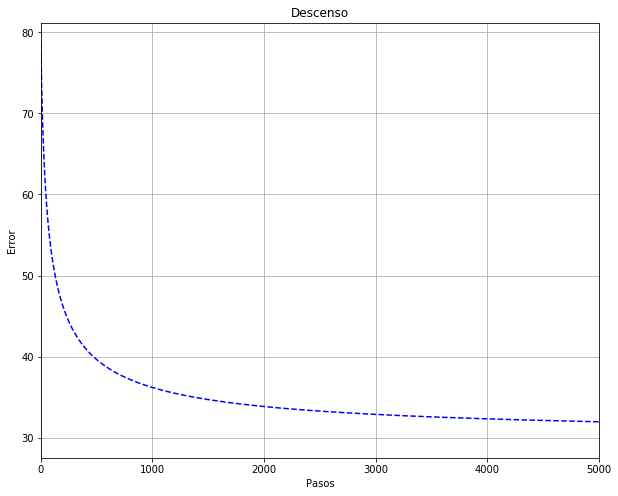

In [89]:
plt.figure(figsize=(10,8))
plt.plot(lost,"b--")
plt.xlabel("Pasos")
plt.ylabel("Error")
plt.title("Descenso", size = 12)
plt.grid(True)
print("Error alcanzado = {}".format(lost[-1]))
plt.xlim(0,5000)

Una vez encontrado los coeficientes debemos prepararlo para hacer predicciones dado dos jugadores cualquiera , para esto debemos construir funciones que pongan el identificador del jugador en terminos de la base de vectores dummy que anteriormente creamos 



In [90]:
t_val = x_val[:,-1]
x = x_train[:,:-1]
J = np.unique(x)
N = len(J)
L = np.zeros((1,N))

pred = []
for i in range(len(x_val)):
    Jug1, Jug2 = x_val[i][:-1]
    L = np.zeros((1,N))
    index = np.where(J == Jug1)
    index2 = np.where(J == Jug2) 
    L[0,index] = 1
    L[0,index2] = 1
    #L = dummy_Jug(Jug1,Jug2)
    a = sigmoid(w.T@L.T)[0,0]
    pred.append(a)

pred = np.array(pred)
probC1 = pred
probC2 = 1-pred
t_pred = []
for i in range(len(pred)):
    if probC1[i] > probC2[i]:
        t_pred.append(0)
    else:
        t_pred.append(1)
t_pred = np.array(t_pred)

sum([t_pred[i] == t_val[i] for i in range(len(pred))])/len(pred)

0.6521739130434783

* Compara el clasificador bayesiano ingenuo y regresión logística en este problema. ¿Qué ventajas y desventajas tienen los modelos entrenados? ¿Qué pasaría si se entrena el clasificador bayesiano ingenuo con los vectores reparametrizados o si se entrena un modelo de regresión logística usando los vectores de entrada originales? ¿Consideras que las presuposiciones de cada clasificador son apropiadas para los datos del problema? ¿Para este tipo de problemas cuál de los dos recomendarías y por qué?

**Naive Bayes** es un método de clasificación basado en el teorema de Bayes que deriva la probabilidad de que el vector de características dado esté asociado con una etiqueta. Tiene una suposicion "ingenua" de independencia condicional para cada característica, es decir que algoritmo espera que las características sean independientes, cosa que no ocurre siempre. la **Regresión logística** es un método de clasificacion lineal que aprende la probabilidad de que una muestra pertenezca a una determinada clase. Intenta encontral el límite de decisión óptimo que se pare mejor las clases

#### 1. Ambos se utilizan para la clasificación

#### 2. Mecanismo de aprendizaje

El arendizaje en cada método es un poco diferente , **Naive Bayes** es un modelo generativo y la **Regresión logística** es un modelo discriminativo 

#### 3. Suposiciones del modelo

**Naive Bayes** asume que todas las características son condicionalmente independientes. Por lo tano, si alguna de las características depende entre si la predicción podría ser deficiente.

**Regresión logística** hereda muchas suposiciones del ajuste lineal corriente, por tanto está construido sobre la suposiciónde independencia lineal y funcionan razonablemente aun cuando estén debilmente correlacionadas las variables independientes

#### 4. ¿Qué condiciones mejoran el rendimiento ?

**Naive Bayes:** cuando el tamaño de los datos de entrenamiento es pequeño en relación con el número de características, la relación (informacion/datos) en las probabilidades apriori ayudan a mejorar los resultado

**Regresión logística:** Cuando el tamaño de los datos de entrenamiento es pequeño relativo al número de características, se debe utilizar regularización para evitar problemas de sobreajuste 



Cuando se reparametriza las variables categóricas se incrementan drásticamente el numero de características que el modelo debe considerar, en el caso del clasificador Bayesiano ingenuo será mucho más costoso el calculo de los estimadores dado que debe hacer una estimación para cada una de las características. Si se ingresan las variables de los jugadores en un modelo de regresión logística va a operar bajo el valor numérico que identifica al jugador y eso no tienen sentido, dado que el numero que se consigna en los datos es un nuero que identifica al jugador y no una característica propia del sistema.

En particular recomendaría pensar en modelos discriminativos **regresión logística **para este problema, dado que debemos suponer menos respecto de los jugadores, cuando se utiliza el calsificador ingenuo se asume una probabilidad apriori tratando de muestrear correctamente los datos, es una propuesta que se hace partiendo de lo que suponemos del sistema, de alguna manera se puede estar violando, bajo la particular elección de la distribución de probabilidad, la independencia condicional de las características y esto puede llevar a malos resultados. Aunque se sabe que el clasificador Bayesiano alcanza el límite asintótico más rápido está más sesgado que la regresión logística y otro punto importante es que en la regresión logística se puede implementar la penalización por norma, esto le posibilita al sistema poder generalizar mejor las predicciones del modelo 

* Deriva la regla de actualización para el algoritmo del descenso por gradiente de un clasificador donde $\hat{y} = \text{sigm}(\vec{\theta}^{T}\vec{x})$ y la función de pérdida sea

$$E(\vec{\theta}) = \frac{1}{2}\sum_{i=1}^{n}(\hat{y}^{(i)}-y^{(i)})$$

 
#### Estimación del vector $\vec{\omega}$ 

La probabilidad de un evento se describe por 

$$P(\vec{y}|\vec{x},\vec{\omega}) = \prod_{n=1}^{N}P(y_{n}|\vec{x}_{n},\vec{\omega}) = \prod_{n=1}^{N}\mu_{n}^{y_{n}}(1-\mu_{n})^{1-y_{n}}\qquad \mu_{n} = \frac{e^{\vec{\omega}^{T}\vec{x}_{n}}}{1+e^{\vec{\omega}^{T}\vec{x}_{n}}}$$

Tomando el logaritmo se llega a la siguiente definición

$$NLL(\vec{\omega}) = -\sum_{n=1}^{N}\left[y_{n}\log \mu_{n}+(1-y_{n})\log (1-\mu_{n})\right]$$

$$NLL(\vec{\omega}) = -\sum_{n=1}^{N}\left[y_{n}\vec{\omega}^{T}\vec{x}_{n}-\log(1-e^{\vec{\omega}^{T}\vec{x}_{n}})\right]$$

Ahora se toma la derivada

$$\vec{g} = \frac{\partial(NLL(\vec{\omega}))}{\partial \vec{\omega}} =\frac{\partial}{\partial \vec{\omega}}\left[\sum_{n=1}^{N}(y_{n}\vec{\omega^{t}}\vec{x}_{n})-\log (1-e^{\vec{\omega}^{t}\vec{x}_{n}})\right]$$

$$\vec{g} = -\sum_{n=1}^{N}\left(y_{n}\vec{x}_{n}-\frac{e^{(\vec{\omega}^{T}\vec{x}_{n})}}{1+e^{\vec{\omega}^{T}\vec{x}_{n}}}\vec{x}_{n}\right)$$

$$\vec{g} = -\sum_{n=1}^{N}(y_{n}-\mu_{n})\vec{x}_{n}$$





No tenemos una solución analítica del tipo $\vec{g} = 0$, entonces vemos que la convexidad de la función asegura un mínimo global, por lo tanto vamos a buscar ese mínimo haciendo que el vector descienda en la dirección de mayor crecimiento, esto se hace de la siguiente manera

$$\vec{\omega}^{\tau+1} = \vec{\omega}^{\tau}-\eta\sum_{n=1}^{N}(\mu_{n}^{\tau}-y_{n})\vec{x}_{n} \qquad \mu_{n}^{\tau} = \text{Sigm}((\omega^{\tau})^{T}\vec{x}_{n}) $$